# Instala o pacote Python chamado cloudscraper usando o pip

###Se você estiver tentando raspar dados de um site que usa Cloudflare, cloudscraper consegue "enganar" esse bloqueio, se comportando como um navegador legítimo.

In [ ]:
!pip install cloudscraper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
import pyspark
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("HelloWorld").getOrCreate()
sc = spark.sparkContext

nums = sc.parallelize([1,2,3,4])
result=nums.map(lambda x: x*x).collect()
print(result)

[1, 4, 9, 16]


# Extração de Dados de Reviews do Site Fragrantica - Web Scraping

In [ ]:
import pandas as pd
import cloudscraper
from bs4 import BeautifulSoup

def scrape_reviews_to_df(perfume_urls):
    scraper = cloudscraper.create_scraper(
        browser={
            'browser': 'chrome',
            'platform': 'windows',
            'mobile': False
        }
    )
    all_reviews = []

    for perfume_url in perfume_urls:
        reviews = []
        page_url = perfume_url

        while page_url:
            resp = scraper.get(page_url)
            resp.raise_for_status()
            soup = BeautifulSoup(resp.text, 'html.parser')

            for box in soup.select('div.fragrance-review-box'):
                author_el = box.select_one('[itemprop="author"] [itemprop="name"]')
                date_el   = box.select_one('[itemprop="datePublished"]')
                perf_el   = box.select_one('.perfume-wearing-icon')
                rate_el   = box.select_one('[rating-vote]')
                text_el   = box.select_one('[itemprop="reviewBody"]')

                reviews.append({
                    'url': perfume_url,
                    'author':      author_el  ['content'] if author_el else None,
                    'date':        date_el    ['content'] if date_el   else None,
                    'perfume':     perf_el    ['title']   if perf_el   else None,
                    'rating':      int(rate_el['rating-vote']) if rate_el else None,
                    'review_text': text_el.get_text(strip=True)   if text_el  else None
                })

            next_link = soup.select_one('ul.pagination li.next a')
            page_url = ('https://www.fragrantica.com.br' + next_link['href']) if next_link else None

        all_reviews.extend(reviews)

    return pd.DataFrame(all_reviews)

if __name__ == '__main__':
    urls = [
        'https://www.fragrantica.com.br/perfume/Carolina-Herrera/Good-Girl-39681.html',
        'https://www.fragrantica.com.br/perfume/Lancome/La-Vie-Est-Belle-14982.html',
        'https://www.fragrantica.com.br/perfume/Yves-Saint-Laurent/Libre-56077.html',
        'https://www.fragrantica.com.br/perfume/Prada/Prada-Paradoxe-75668.html',
        'https://www.fragrantica.com.br/perfume/Jean-Paul-Gaultier/Scandal-45651.html',
        'https://www.fragrantica.com.br/perfume/Giorgio-Armani/My-Way-62036.html',
        'https://www.fragrantica.com.br/perfume/Dior/J-Adore-L-Or-10371.html',
        'https://www.fragrantica.com.br/perfume/Giorgio-Armani/Si-18453.html',
        'https://www.fragrantica.com.br/perfume/Yves-Saint-Laurent/Black-Opium-Eau-de-Toilette-31440.html',
        'https://www.fragrantica.com.br/perfume/Chanel/Coco-Mademoiselle-611.html',
        'https://www.fragrantica.com.br/perfume/Lancome/Idole-55795.html',
        'https://www.fragrantica.com.br/perfume/Dior/Miss-Dior-Eau-de-Parfum-2021-68905.html',
        'https://www.fragrantica.com.br/perfume/Calvin-Klein/Euphoria-253.html',
        'https://www.fragrantica.com.br/perfume/Givenchy/L-Interdit-Eau-de-Parfum-51488.html'

        # Add more URLs as needed
    ]
    df = scrape_reviews_to_df(urls)
    print(df)



                                                    url  \
0     https://www.fragrantica.com.br/perfume/Carolin...   
1     https://www.fragrantica.com.br/perfume/Carolin...   
2     https://www.fragrantica.com.br/perfume/Carolin...   
3     https://www.fragrantica.com.br/perfume/Carolin...   
4     https://www.fragrantica.com.br/perfume/Carolin...   
...                                                 ...   
2456  https://www.fragrantica.com.br/perfume/Givench...   
2457  https://www.fragrantica.com.br/perfume/Givench...   
2458  https://www.fragrantica.com.br/perfume/Givench...   
2459  https://www.fragrantica.com.br/perfume/Givench...   
2460  https://www.fragrantica.com.br/perfume/Givench...   

                     author        date                               perfume  \
0                  Sylvinha  2025-06-06  Valentino Donna Born In Roma Intense   
1                    Mah C.  2025-06-01                                  None   
2                bbrendinha  2025-05-30         

# Página de busca da **Fragrantica Brasil** para coletar perfumes femininos lançados em 2023.

In [ ]:
import cloudscraper
from bs4 import BeautifulSoup

search_url = "https://www.fragrantica.com.br/busca/?godina=2023%3A&spol=female"
scraper = cloudscraper.create_scraper(
    browser={"browser": "chrome", "platform": "windows", "mobile": False}
)
resp = scraper.get(search_url)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, "html.parser")

In [ ]:
perfumes = []
for card in soup.select("div.fr-news-box"):
    a_tag = card.select_one('a[href^="/perfume/"]')
    if not a_tag:
        continue

    href = a_tag["href"]  # e.g. "/perfume/Burberry/Goddess-83483.html"
    if not href.startswith("/perfume/"):
        continue
    full_url = "https://www.fragrantica.com.br" + href
    name = a_tag.get_text(strip=True)

    perfumes.append((name, full_url))
perfumes

[('Azzaro Orange Tonic',
  'https://www.fragrantica.com.br/perfume/Azzaro/Orange-Tonic-1.html'),
 ('Givenchy Amarige',
  'https://www.fragrantica.com.br/perfume/Givenchy/Amarige-3.html'),
 ('Givenchy Organza',
  'https://www.fragrantica.com.br/perfume/Givenchy/Organza-4.html'),
 ("Dior J'adore Eau de Toilette 2002",
  'https://www.fragrantica.com.br/perfume/Dior/J-adore-Eau-de-Toilette-2002-5.html'),
 ('Lanvin Arpège',
  'https://www.fragrantica.com.br/perfume/Lanvin/Arpege-6.html'),
 ('Hermès Equipage',
  'https://www.fragrantica.com.br/perfume/Hermes/Equipage-7.html'),
 ('Hermès Rouge Hermes Eau Delicate',
  'https://www.fragrantica.com.br/perfume/Hermes/Rouge-Hermes-Eau-Delicate-8.html'),
 ('Hermès Eau des Merveilles',
  'https://www.fragrantica.com.br/perfume/Hermes/Eau-des-Merveilles-9.html'),
 ('Hermès Parfum des Merveilles',
  'https://www.fragrantica.com.br/perfume/Hermes/Parfum-des-Merveilles-10.html'),
 ('Chanel Chanel N°19',
  'https://www.fragrantica.com.br/perfume/Chanel/C

# Coleta das Avaliações de Cada Perfume

In [ ]:
def scrape_reviews_to_df(perfume_urls):
    scraper = cloudscraper.create_scraper(
        browser={
            'browser': 'chrome',
            'platform': 'windows',
            'mobile': False
        }
    )
    all_reviews = []

    for perfume_url in perfume_urls:
        reviews = []
        page_url = perfume_url

        while page_url:
            resp = scraper.get(page_url)
            resp.raise_for_status()
            soup = BeautifulSoup(resp.text, 'html.parser')

            for box in soup.select('div.fragrance-review-box'):
                author_el = box.select_one('[itemprop="author"] [itemprop="name"]')
                date_el   = box.select_one('[itemprop="datePublished"]')
                perf_el   = box.select_one('.perfume-wearing-icon')
                rate_el   = box.select_one('[rating-vote]')
                text_el   = box.select_one('[itemprop="reviewBody"]')

                reviews.append({
                    'url': perfume_url,
                    'author':      author_el  ['content'] if author_el else None,
                    'date':        date_el    ['content'] if date_el   else None,
                    'perfume':     perf_el    ['title']   if perf_el   else None,
                    'rating':      int(rate_el['rating-vote']) if rate_el else None,
                    'review_text': text_el.get_text(strip=True)   if text_el  else None
                })

            next_link = soup.select_one('ul.pagination li.next a')
            page_url = ('https://www.fragrantica.com.br' + next_link['href']) if next_link else None

        all_reviews.extend(reviews)

    return pd.DataFrame(all_reviews)

In [ ]:
all_reviews_df = pd.DataFrame()

for (perfume_name, perfume_url) in perfumes:
    print(f"\n=== Scraping reviews for: {perfume_name} ===")
    df_reviews = scrape_reviews_to_df([perfume_url])
    all_reviews_df = pd.concat([all_reviews_df, df_reviews], ignore_index=True)
print(all_reviews_df.head())


=== Scraping reviews for: Azzaro Orange Tonic ===

=== Scraping reviews for: Givenchy Amarige ===

=== Scraping reviews for: Givenchy Organza ===

=== Scraping reviews for: Dior J'adore Eau de Toilette 2002 ===

=== Scraping reviews for: Lanvin Arpège ===

=== Scraping reviews for: Hermès Equipage ===

=== Scraping reviews for: Hermès Rouge Hermes Eau Delicate ===

=== Scraping reviews for: Hermès Eau des Merveilles ===

=== Scraping reviews for: Hermès Parfum des Merveilles ===

=== Scraping reviews for: Chanel Chanel N°19 ===

=== Scraping reviews for: Chanel Cristalle Eau de Toilette ===

=== Scraping reviews for: Guerlain Apres l'Ondee ===

=== Scraping reviews for: Lanvin Arpege Pour Homme ===

=== Scraping reviews for: Robert Piguet Bandit ===

=== Scraping reviews for: Guerlain Habit Rouge Eau de Toilette ===

=== Scraping reviews for: Hermès Terre d'Hermès ===

=== Scraping reviews for: Hermès Un Jardin Sur Le Nil ===

=== Scraping reviews for: Hermès Un Jardin en Méditerranée

HTTPError: 429 Client Error: Too Many Requests for url: https://www.fragrantica.com.br/perfume/Givenchy/Givenchy-pour-Homme-Blue-Label-38.html

In [ ]:
dados = " ".join(all_reviews_df["review_text"].astype(str))
dados

'Esse perfume é maravilhoso. Junto com o Laguna (Salvador Dalí) e o Flower by Kenzo é uma das fragrâncias que me lembra minha mãe, a mulher mais cheirosa que existe!Lembro que ela comprou esse perfume numa promoção da época (devia ser 2005/2006) por uns R$ 40,00. Hoje ele nem é fabricado mais, e se você encontra por aí é num preço absurdo. Daria tudo pra achar um perfume que se assemelhasse a ele, pois tenho lembranças gostosas demais de pegar ele escondida do armário dela e passar pra sair. Um cheiro super fresquinho e inocente, e projeta muuuito a bergamota. Na medida que o tempo passa com ele na pele fica um cítrico mais atenuado, suavinho e gostoso.Saudade demais! Me lembra cheiro de urina no fundo,fiquei triste pois amo cheirinho de laranja. Esse perfume é maravilhoso. Junto com o Laguna (Salvador Dalí) e o Flower by Kenzo é uma das fragrâncias que me lembra minha mãe, a mulher mais cheirosa que existe!Lembro que ela comprou esse perfume numa promoção da época (devia ser 2005/2006

# Buscando no texto palavras pré-selecionadas

In [ ]:
import re

chaves = [ "acessório", "acompanhamento", "alongamento", "amadeirado", "amo", "atitude", "autoamor", "autoestima",
    "autoimagem", "autocuidado", "autoconfiança", "autenticidade", "beleza", "blogueira", "bodysplash",
    "bolsa", "bolsas", "celebridades", "Chanel", "charme", "closet", "comprinha", "confiança", "conforto",
    "cosméticos", "cupom", "date", "dancinha", "descoberta", "destino", "Dior", "doce", "e-commerce",
    "elegância", "elegante", "emoção", "energia", "enjoativo", "estampas", "estilo", "exclusividade",
    "experiência", "expressão", "falsificado", "favorito", "felicidade", "feminilidade", "feminino",
    "Floral", "força", "Fraco", "frescura", "Frutado", "glamour", "Glow", "Gucci", "hidratação",
    "identidade", "impressiona", "importado", "influencer", "influenciadora", "instagram", "instagramável",
    "inspiração", "irresistivel", "irresistiveis", "Lancôme", "lembrança", "lifestyle", "lip oil", "look",
    "looks", "Longa", "lugar", "luxo", "maquiagem", "Marcante", "memória", "minimalismo", "moda",
    "momento", "Mugler", "necessaire", "Original", "oriental", "outfit", "passaporte", "pele",
    "personalidade", "poder", "popular", "praia", "prazer", "presente", "presentinho", "produto",
    "protagonismo", "promoção", "refrescante", "relaxamento", "resenha", "Réplica", "rosto", "rotina",
    "Sedutor", "sensação", "sensual", "sensualidade", "serum", "Sexy", "signos", "similar", "skincare",
    "social", "sofisticado", "stories", "suavidade", "tendência", "testador", "TikTok", "toque",
    "transformação", "vibe", "verão", "vício", "viagem", "vitrine", "wishlist", "YSL"]
chaves_upper = [k.upper() for k in chaves]


# Verificando a frequência das palavras

In [ ]:
# Junta todas as reviews em um único texto e coloca em maiúsculas
dados = " ".join(all_reviews_df["review_text"].astype(str)).upper()

# Palavras-chave em maiúsculas para facilitar comparação
chaves_upper = [c.upper() for c in chaves]

# Cria um RDD com as palavras-chave, paralelizando a busca
input_rdd = sc.parallelize(chaves_upper, 3)

# Função que conta quantas vezes a chave aparece no texto
def count_keyword_occurrence(chave):
    count = dados.count(chave)
    if count > 0:
        return (chave, count)
    else:
        return None

# Aplica a contagem no RDD
counts_rdd = (
    input_rdd
    .map(count_keyword_occurrence)
    .filter(lambda x: x is not None)
)

# Coleta os resultados
result = counts_rdd.collect()

# Exibe
print(result)

[('ACESSÓRIO', 1), ('AMADEIRADO', 139), ('AMO', 346), ('AUTOESTIMA', 1), ('AUTOCONFIANÇA', 2), ('BELEZA', 20), ('BOLSA', 6), ('BOLSAS', 3), ('CHANEL', 61), ('CHARME', 3), ('CONFIANÇA', 11), ('CONFORTO', 19), ('COSMÉTICOS', 3), ('DATE', 1), ('DESCOBERTA', 5), ('DIOR', 13), ('DOCE', 147), ('ELEGÂNCIA', 39), ('ELEGANTE', 215), ('EMOÇÃO', 1), ('ENERGIA', 5), ('ENJOATIVO', 18), ('ESTILO', 49), ('EXCLUSIVIDADE', 9), ('EXPERIÊNCIA', 31), ('EXPRESSÃO', 1), ('FALSIFICADO', 1), ('FAVORITO', 27), ('FELICIDADE', 16), ('FEMINILIDADE', 9), ('FEMININO', 76), ('FLORAL', 297), ('FORÇA', 24), ('FRACO', 4), ('FRESCURA', 1), ('FRUTADO', 27), ('GLAMOUR', 1), ('GLOW', 1), ('GUCCI', 3), ('HIDRATAÇÃO', 1), ('IDENTIDADE', 6), ('IMPRESSIONA', 9), ('IMPORTADO', 23), ('INSTAGRAM', 6), ('INSPIRAÇÃO', 2), ('IRRESISTIVEL', 2), ('LANCÔME', 1), ('LEMBRANÇA', 24), ('LOOK', 2), ('LONGA', 18), ('LUGAR', 43), ('LUXO', 22), ('MAQUIAGEM', 10), ('MARCANTE', 73), ('MEMÓRIA', 36), ('MODA', 54), ('MOMENTO', 70), ('MUGLER', 2), 

# Ordenando

In [ ]:
ordenado = sorted(result, key=lambda x: x[1], reverse=True)
print(ordenado)

[('AMO', 346), ('PELE', 336), ('FLORAL', 297), ('ELEGANTE', 215), ('DOCE', 147), ('AMADEIRADO', 139), ('PODER', 106), ('SENSAÇÃO', 88), ('TOQUE', 86), ('RESENHA', 81), ('FEMININO', 76), ('MARCANTE', 73), ('MOMENTO', 70), ('CHANEL', 61), ('PRESENTE', 61), ('SENSUAL', 57), ('SOFISTICADO', 57), ('PERSONALIDADE', 56), ('MODA', 54), ('ESTILO', 49), ('VIBE', 44), ('LUGAR', 43), ('VERÃO', 41), ('ELEGÂNCIA', 39), ('MEMÓRIA', 36), ('EXPERIÊNCIA', 31), ('ORIGINAL', 29), ('REFRESCANTE', 29), ('FAVORITO', 27), ('FRUTADO', 27), ('FORÇA', 24), ('LEMBRANÇA', 24), ('ORIENTAL', 24), ('IMPORTADO', 23), ('LUXO', 22), ('PRODUTO', 22), ('BELEZA', 20), ('CONFORTO', 19), ('ENJOATIVO', 18), ('LONGA', 18), ('SEXY', 18), ('FELICIDADE', 16), ('PRAZER', 16), ('SENSUALIDADE', 16), ('PRAIA', 14), ('VIAGEM', 14), ('DIOR', 13), ('SIMILAR', 12), ('CONFIANÇA', 11), ('PROMOÇÃO', 11), ('SEDUTOR', 11), ('MAQUIAGEM', 10), ('EXCLUSIVIDADE', 9), ('FEMINILIDADE', 9), ('IMPRESSIONA', 9), ('ROSTO', 7), ('SOCIAL', 7), ('BOLSA', 

# Criação da Nuvem de Palavras

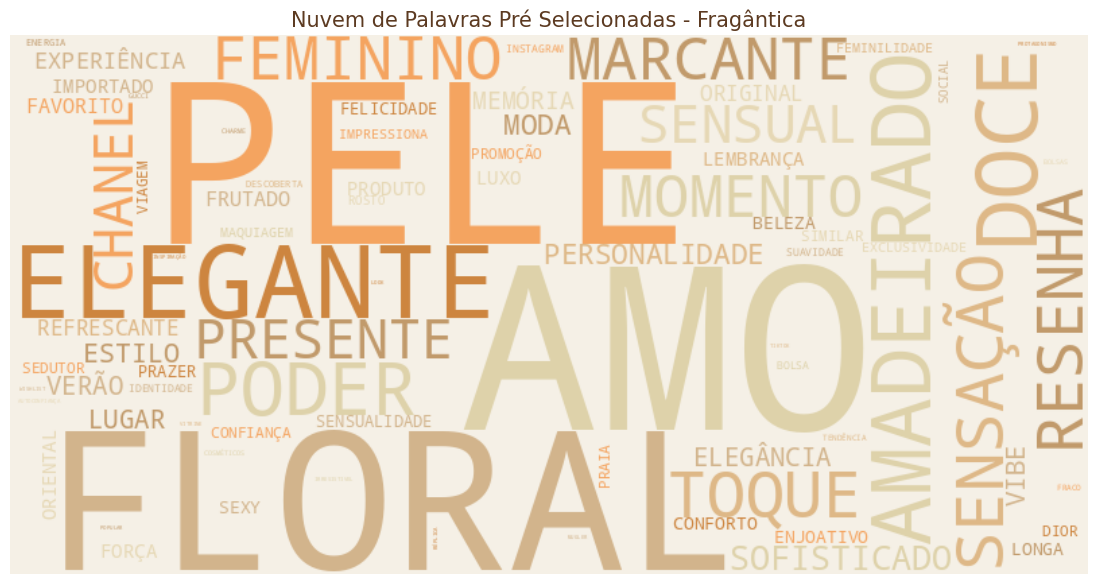

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

def marrom_pastel_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Tons marrons pastéis suaves
    pastel_browns = [
        (210, 180, 140),  # Tan (bege amarronzado)
        (222, 184, 135),  # Burlywood (caramelo claro)
        (244, 164, 96),   # Sandy brown
        (205, 133, 63),   # Peru (marrom claro)
        (193, 154, 107),  # bege médio amarronzado
        (222, 210, 170),  # bege claro amarelado
        (230, 216, 181),  # bege pastel
    ]
    r, g, b = random.choice(pastel_browns)
    return f"rgb({r}, {g}, {b})"

frequencies = dict(ordenado)

wordcloud = WordCloud(width=800, height=400, background_color='#f5f0e6').generate_from_frequencies(frequencies)  # fundo bege claro

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud.recolor(color_func=marrom_pastel_color_func), interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras Pré Selecionadas - Fragântica", color='#5C3A21', fontsize=15)
plt.show()



# Termos Específicos

In [ ]:
import re

termos = [    "acessórios de luxo feminino", "amor próprio", "amor verdadeiro", "amostra grátis", "aroma acolhedor",
    "arrependimento de compra", "autenticidade feminina", "beleza de dentro pra fora", "beleza natural",
    "beleza no verão", "blogueira famosa", "body splash", "café da manhã leve", "Carolina Herrera",
    "cheiro artificial", "cheiro de abraço", "cheiro de álcool", "cheiro de conforto", "cheiro de mulher rica",
    "cheiro marcante", "cheiro marcante e sofisticado", "cheiro que chama atenção", "cheiro que fixa",
    "checklist do dia", "cirurgia plastica", "como ser inesquecível", "como ser mais elegante",
    "como ser mais estilosa", "comprar online", "comprei influenciada", "comprei no escuro",
    "conteúdo de moda", "cronograma capilar", "desejo de consumo", "detalhes que fazem a diferença",
    "destino romântico", "destinos internacionais", "diário da gratidão", "dica de amiga", "dica de hotel",
    "dicas de autoestima", "dicas de beleza", "dicas para conquistar", "dicas para se sentir poderosa",
    "edição limitada", "energia boa", "energia feminina", "esperava mais", "estilo de mulher poderosa",
    "estilo de vida", "experiência de compra", "experiência única", "favoritos da necessaire",
    "feed organizado", "feminilidade moderna", "feminino marcante", "fixação forte", "fragrância assinatura",
    "fragrância de luxo", "fragrância envolvente", "frases de amor", "hotel dos sonhos", "idéia de surpresa",
    "ideias de presente para mulheres", "influenciadora de beleza", "influenciadoras de moda",
    "inspiração de estilo", "intensidade do perfume", "it girl", "item de desejo", "jantar romântico",
    "lifestyle caro", "lifestyle viajante", "look comfy", "look do dia", "look para jantar",
    "looks com personalidade", "looks elegantes e femininos", "looks para viajar", "luxo acessível",
    "luxo discreto", "marca de luxo", "me apaixonei pelo cheiro", "me decepcionou", "me faz lembrar alguém", "me faz lembrar", "me lembra"
    "me faz sentir", "me faz sentir confiante", "me senti poderosa", "melhor perfume para cada tipo de pele",
    "me faz sentir confiante", "me senti poderosa", "melhor perfume para cada tipo de pele",
    "melhores perfumes femininos", "melhores perfumes segundo influenciadoras", "mensagem fofa",
    "minha assinatura", "moda consciente", "moda feminina", "moda feminina 2025", "momento a dois",
    "momento único", "momento", "must-have de beleza", "não dura na pele", "não gostei",
    "não largo mais", "não vale o preço", "nova coleção", "o que usar em um primeiro encontro",
    "passagem promocional", "pele perfeita", "perfume amadeirado", "perfume assinatura",
    "perfume bom e duradouro", "perfume comum", "perfume com boa fixação", "perfume com boa projeção",
    "perfume com identidade", "perfume da minha vida", "perfume das famosas", "perfume de mulher elegante",
    "perfume de mulher poderosa", "perfume de verão", "perfume doce", "perfume elegante",
    "perfume enjoativo", "perfume exclusivo", "perfume feminino mais elogiado", "perfume floral",
    "perfume fraco", "perfume fresco", "perfume frutado", "perfume gourmand",
    "perfume ideal para casamento", "perfume importado original", "perfume leve para o dia",
    "perfume muito caro", "perfume noturno", "perfume para casamento", "perfume para conquistar",
    "perfume para encontros", "perfume para levantar o astral", "perfume para namorar",
    "perfume para o dia a dia", "perfume para o inverno", "perfume para o verão",
    "perfume para presentear", "perfume para primeira impressão", "perfume para sair à noite",
    "perfume para trabalho", "perfume que impressiona", "perfume que marca presença",
    "perfume que rende elogios", "perfume que some rápido", "perfume sedutor", "perfume sem fixação",
    "perfume sofisticado", "perfume unissex", "praia paradisíaca", "presente de press kit",
    "presente especial", "presente para namorada", "produtinhos que amo", "produto premium",
    "produto queridinho", "produto viral", "produtos que duram o dia inteiro", "promoção especial",
    "relacionamento saudável", "resenha de perfume importado", "resenha sincera", "review de beleza",
    "review honesto", "ritual de beleza", "rotina de autocuidado", "rotina de cuidados",
    "rotina de final de semana", "rotina produtiva", "roupa de luxo", "sensação de frescor",
    "spa day", "style tips", "tendência do momento", "tendências de beleza", "tendências de beleza 2025",
    "tendências de moda", "tendências fashion Brasil", "tipos de pele", "toque pessoal",
    "top 10 perfumes femininos 2025", "top favoritos", "trend alert", "unboxing perfume importado",
    "vibe feminina", "vibes positivas", "vale a pena perfume X?", "vale o hype?", "verão fashion",
    "vício do momento", "vida luxuosa", "vida saudável", "viagem com estilo", "viagem dos sonhos",
    "viajar sozinha", "vídeo viral", "virou meu favorito"
]
termos_upper = [k.upper() for k in termos]


In [ ]:
# Junta todas as reviews em um único texto e coloca em maiúsculas
dados = " ".join(all_reviews_df["review_text"].astype(str)).upper()

# Palavras-chave em maiúsculas para facilitar comparação
termos_upper = [c.upper() for c in termos]

# Cria um RDD com as palavras-chave, paralelizando a busca
input_rdd = sc.parallelize(termos_upper, 3)

# Função que conta quantas vezes a chave aparece no texto
def count_keyword_occurrence(termos):
    count = dados.count(termos)
    if count > 0:
        return (termos, count)
    else:
        return None

# Aplica a contagem no RDD
counts_rdd = (
    input_rdd
    .map(count_keyword_occurrence)
    .filter(lambda x: x is not None)
)

# Coleta os resultados
result = counts_rdd.collect()

# Exibe
print(result)

[('BODY SPLASH', 1), ('CAROLINA HERRERA', 1), ('CHEIRO DE CONFORTO', 1), ('CHEIRO DE MULHER RICA', 1), ('COMPREI NO ESCURO', 3), ('ESPERAVA MAIS', 5), ('FRAGRÂNCIA ASSINATURA', 1), ('JANTAR ROMÂNTICO', 1), ('ME DECEPCIONOU', 1), ('ME FAZ LEMBRAR', 3), ('MINHA ASSINATURA', 12), ('MOMENTO', 70), ('NÃO GOSTEI', 8), ('NÃO VALE O PREÇO', 1), ('PERFUME AMADEIRADO', 5), ('PERFUME ASSINATURA', 11), ('PERFUME COMUM', 1), ('PERFUME DA MINHA VIDA', 4), ('PERFUME DE MULHER PODEROSA', 1), ('PERFUME DOCE', 7), ('PERFUME ELEGANTE', 9), ('PERFUME FLORAL', 4), ('PERFUME FRACO', 3), ('PERFUME FRESCO', 13), ('PERFUME FRUTADO', 1), ('PERFUME GOURMAND', 2), ('PERFUME IMPORTADO ORIGINAL', 1), ('PERFUME NOTURNO', 1), ('PERFUME PARA O DIA A DIA', 2), ('PERFUME SOFISTICADO', 3), ('TOP FAVORITOS', 1)]


In [ ]:
termos_ordenado = sorted(result, key=lambda x: x[1], reverse=True)
print(ordenado)

[('AMO', 346), ('PELE', 336), ('FLORAL', 297), ('ELEGANTE', 215), ('DOCE', 147), ('AMADEIRADO', 139), ('PODER', 106), ('SENSAÇÃO', 88), ('TOQUE', 86), ('RESENHA', 81), ('FEMININO', 76), ('MARCANTE', 73), ('MOMENTO', 70), ('CHANEL', 61), ('PRESENTE', 61), ('SENSUAL', 57), ('SOFISTICADO', 57), ('PERSONALIDADE', 56), ('MODA', 54), ('ESTILO', 49), ('VIBE', 44), ('LUGAR', 43), ('VERÃO', 41), ('ELEGÂNCIA', 39), ('MEMÓRIA', 36), ('EXPERIÊNCIA', 31), ('ORIGINAL', 29), ('REFRESCANTE', 29), ('FAVORITO', 27), ('FRUTADO', 27), ('FORÇA', 24), ('LEMBRANÇA', 24), ('ORIENTAL', 24), ('IMPORTADO', 23), ('LUXO', 22), ('PRODUTO', 22), ('BELEZA', 20), ('CONFORTO', 19), ('ENJOATIVO', 18), ('LONGA', 18), ('SEXY', 18), ('FELICIDADE', 16), ('PRAZER', 16), ('SENSUALIDADE', 16), ('PRAIA', 14), ('VIAGEM', 14), ('DIOR', 13), ('SIMILAR', 12), ('CONFIANÇA', 11), ('PROMOÇÃO', 11), ('SEDUTOR', 11), ('MAQUIAGEM', 10), ('EXCLUSIVIDADE', 9), ('FEMINILIDADE', 9), ('IMPRESSIONA', 9), ('ROSTO', 7), ('SOCIAL', 7), ('BOLSA', 

# Exibir resultados em formato de tabela

In [ ]:
import pandas as pd

tabela_resultado = pd.DataFrame(result, columns=["Termo", "Frequência"])

# Ordena do maior para o menor
tabela_resultado = tabela_resultado.sort_values(by="Frequência", ascending=False).reset_index(drop=True)

# Exibe a tabela
print(tabela_resultado)



                         Termo  Frequência
0                      MOMENTO          70
1               PERFUME FRESCO          13
2             MINHA ASSINATURA          12
3           PERFUME ASSINATURA          11
4             PERFUME ELEGANTE           9
5                   NÃO GOSTEI           8
6                 PERFUME DOCE           7
7           PERFUME AMADEIRADO           5
8                ESPERAVA MAIS           5
9        PERFUME DA MINHA VIDA           4
10              PERFUME FLORAL           4
11               PERFUME FRACO           3
12         PERFUME SOFISTICADO           3
13           COMPREI NO ESCURO           3
14              ME FAZ LEMBRAR           3
15    PERFUME PARA O DIA A DIA           2
16            PERFUME GOURMAND           2
17              ME DECEPCIONOU           1
18                 BODY SPLASH           1
19          CHEIRO DE CONFORTO           1
20            CAROLINA HERRERA           1
21       CHEIRO DE MULHER RICA           1
22       FR

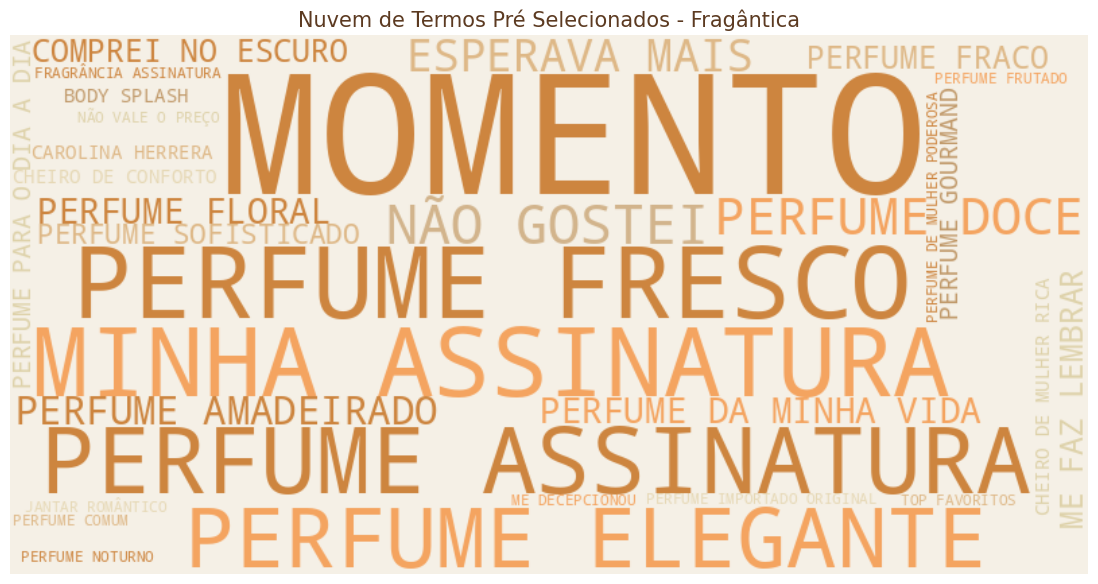

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

def marrom_pastel_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Tons marrons pastéis suaves
    pastel_browns = [
        (210, 180, 140),  # Tan (bege amarronzado)
        (222, 184, 135),  # Burlywood (caramelo claro)
        (244, 164, 96),   # Sandy brown
        (205, 133, 63),   # Peru (marrom claro)
        (193, 154, 107),  # bege médio amarronzado
        (222, 210, 170),  # bege claro amarelado
        (230, 216, 181),  # bege pastel
    ]
    r, g, b = random.choice(pastel_browns)
    return f"rgb({r}, {g}, {b})"

frequencies = dict(termos_ordenado)

wordcloud = WordCloud(width=800, height=400, background_color='#f5f0e6').generate_from_frequencies(frequencies)  # fundo bege claro

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud.recolor(color_func=marrom_pastel_color_func), interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Termos Pré Selecionados - Fragântica", color='#5C3A21', fontsize=15)
plt.show()

